In [88]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import uncertainties as unc

In [89]:
def linear_fit(x, a, b):
    return a*x + b

1.504+/-0.006


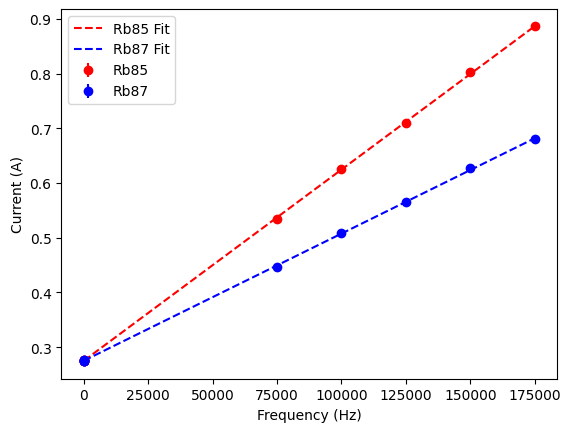

In [90]:
frequencies = np.array([0,0,0,0,0,75e3, 100e3, 125e3, 150e3, 175e3])
#uncs here should be 0.001
rb87 = np.array([0.274,0.275,0.276,0.277,0.275,0.447,0.508,0.565,0.627,0.680])
rb85 = np.array([0.274,0.275,0.276,0.277,0.275,0.535,0.625,0.710,0.802,0.886])
popt1, pcov1 = curve_fit(linear_fit, frequencies, rb85, sigma = 0.001*np.ones(len(frequencies)))
popt2, pcov2 = curve_fit(linear_fit, frequencies, rb87, sigma = 0.001*np.ones(len(frequencies)))
slope1 = unc.ufloat(popt1[0], np.sqrt(pcov1[0,0]))
slope2 = unc.ufloat(popt2[0], np.sqrt(pcov2[0,0]))
slope1 = 1/slope1
slope2 = 1/slope2
print(slope2/slope1)



plt.errorbar(frequencies, rb85, fmt = 'ro', yerr= 0.001, label='Rb85')
plt.errorbar(frequencies, rb87, fmt = 'bo', yerr= 0.001, label='Rb87')
plt.plot(frequencies, linear_fit(frequencies, *popt1), 'r--', label='Rb85 Fit')
plt.plot(frequencies, linear_fit(frequencies, *popt2), 'b--', label='Rb87 Fit')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Current (A)')

plt.legend()


[ 0.6101369  -0.16629433]


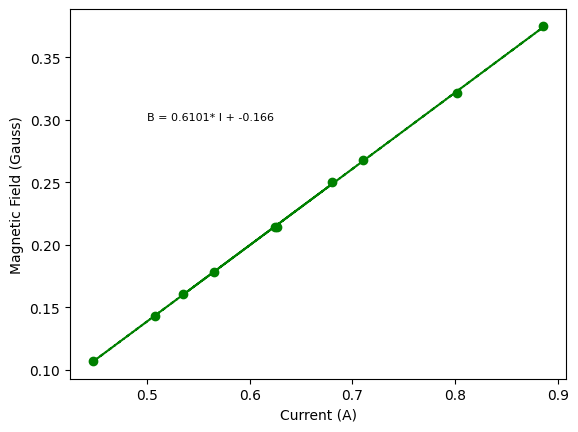

In [91]:
rb85Transitions = rb85[5:]
rb87Transitions = rb87[5:]
transitionFreqs = frequencies[5:]
B85 = transitionFreqs/1.3996e6*3
B87 = transitionFreqs/1.3996e6*2
BS = np.concatenate((B85, B87))
Is = np.concatenate((rb85Transitions, rb87Transitions))
popt3, pcov3 = curve_fit(linear_fit, Is, BS)
print(popt3)
plt.plot(Is, linear_fit(Is, *popt3), 'g--', label='Fit')
plt.plot(Is, BS, 'go', label='Data')
plt.text(0.5, 0.3, 'B = ' + str(popt3[0])[:6] + '* I + ' + str(popt3[1])[:6], fontsize=8)
plt.xlabel('Current (A)')
plt.ylabel('Magnetic Field (Gauss)')
plt.show()

def sweepB(I):
    return popt3[0]*I + popt3[1]



[8.65685128] 0.045399770459633774


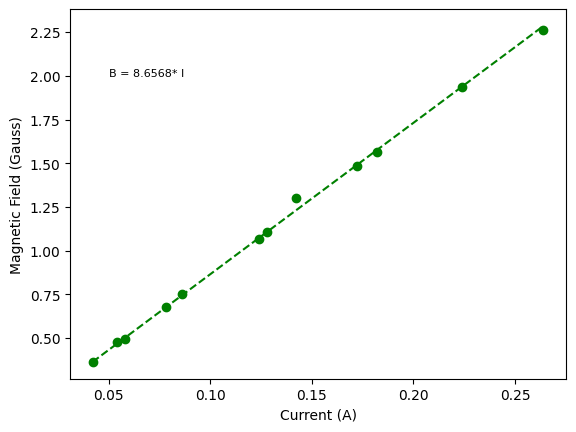

In [92]:
def slopeFit(x, a):
    return a*x
frequencies = np.array([1e6, 850e3, 650e3, 450e3, 250e3, 150e3])
zeroFieldSweep = np.array([0.019, 0.065, 0.021, 0.029,0.040, 0.019])
zeroFieldMain = np.array([0.008, 0.007, 0.008, 0.008, 0.008, 0.009])*2
firstPeakSweep = np.array([0.054, 0.135,0.043, 0.094, 0.044, 0.026 ])
firstPeakMain = np.array([0.091, 0.071, 0.062, 0.043, 0.029, 0.021])*2
secondPeakSweep = np.array([0.081, 0.083, 0.121, 0.042, 0.040, 0.020])
secondPeakMain = np.array([0.132, 0.112, 0.086, 0.064, 0.039, 0.027])*2
B85MainCal = frequencies/1.3996e6*3
B87MainCal = frequencies/1.3996e6*2
firstPeakMainB = B87MainCal - sweepB(firstPeakSweep)
secondPeakMainB = B85MainCal - sweepB(secondPeakSweep)
mainFieldBs = np.concatenate((firstPeakMainB, secondPeakMainB))
mainFieldIs = np.concatenate((firstPeakMain, secondPeakMain))
sortedIs = np.sort(mainFieldIs)
popt4, pcov4 = curve_fit(slopeFit, mainFieldIs, mainFieldBs)
print(popt4, np.sqrt(pcov4[0,0]))
plt.plot(sortedIs, slopeFit(sortedIs, *popt4), 'g--', label='Fit')
plt.plot(mainFieldIs, mainFieldBs, 'go', label='Data')
plt.text(0.05, 2, 'B = ' + str(popt4[0])[:6] + '* I', fontsize=8)
plt.xlabel('Current (A)')
plt.ylabel('Magnetic Field (Gauss)')
plt.show()

def BField(mainCoilCurrent, sweepCoilCurrent):
    return sweepB(sweepCoilCurrent) + popt4[0]*mainCoilCurrent


In [93]:
fiveMegVoltage = 6.5e6/1.3996e6*2/popt4[0]/2
print(5e6/1.3996e6*2)
print(fiveMegVoltage)

7.144898542440697
0.536474972510782


In [122]:
#omega I +1/2 solution
def omegaIplushalf(omega, mBar, g_f, F):
    J = 1/2
    I =3/2
    mu_N = 5.0507837393e-31
    mu_I= 2.751324*mu_N
    g_j =g_f*(2*F*(F+1))/(F*(F+1) - I*(I+1) + J*(J+1))
    mu_b = 9.274e-28
    hbar = 1.0545718e-34
    a = -2*mBar*((g_j*mu_b + mu_I/I)**2)/(((2*I + 1)**2)*hbar**2*6834.7e6*2*np.pi)
    b = (g_j*mu_b - 2*mu_I)/((2*I + 1)*hbar)
    c = -omega
    return (-b + np.sqrt(b**2 - 4*a*c))/(2*a), (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

print(omegaIplushalf(2*np.pi*5e6, 1.5, 1/2, 2))

(np.float64(7.171339933665279), np.float64(3240.2015157812943))


[7.196513   7.93696112 8.65231415 9.3804006 ]
[0.74105826 0.72816591 0.73845877]
[0.73861771 0.7263355  0.73479795]
[0.7367873  0.72389495 0.73113713]
[0.74044812 0.71535304 0.72808644]


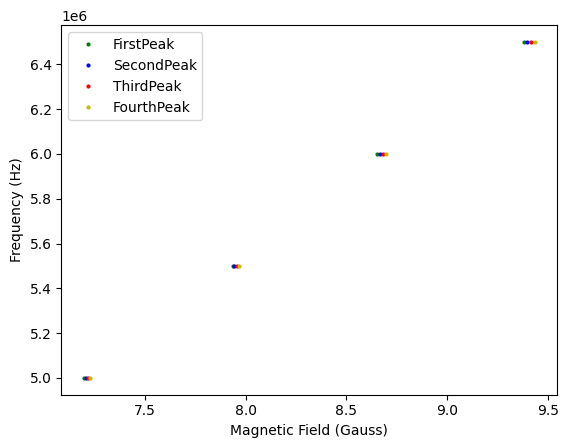

In [116]:
frequencies = np.array([5e6, 5.5e6, 6e6, 6.5e6])
mainCoilCurrents = np.array([0.410, 0.454, 0.495, 0.533])*2
firstPeaks = np.array([0.433, 0.398, 0.407, 0.522])
secondPeaks = np.array([0.45, 0.409, 0.432, 0.552])
thridPeaks = np.array([0.468, 0.430, 0.457, 0.583])
fourthPeaks = np.array([0.485, 0.451, 0.481, 0.613])
firstPeakBs = BField(mainCoilCurrents, firstPeaks)
print(firstPeakBs)
secondPeakBs = BField(mainCoilCurrents, secondPeaks)
thirdPeakBs = BField(mainCoilCurrents, thridPeaks)
fourthPeakBs = BField(mainCoilCurrents, fourthPeaks)
print(fourthPeakBs[1:] - fourthPeakBs[:-1])
print(thirdPeakBs[1:] - thirdPeakBs[:-1])
print(secondPeakBs[1:] - secondPeakBs[:-1])
print(firstPeakBs[1:] - firstPeakBs[:-1])

plt.plot(firstPeakBs, frequencies, "go", label='FirstPeak', markersize=2)
plt.plot(secondPeakBs, frequencies, "bo", label='SecondPeak', markersize=2)
plt.plot(thirdPeakBs, frequencies, "ro", label='ThirdPeak', markersize=2)
plt.plot(fourthPeakBs, frequencies, "yo", label='FourthPeak', markersize=2)
plt.legend()
plt.xlabel('Magnetic Field (Gauss)')
plt.ylabel('Frequency (Hz)')
plt.show()


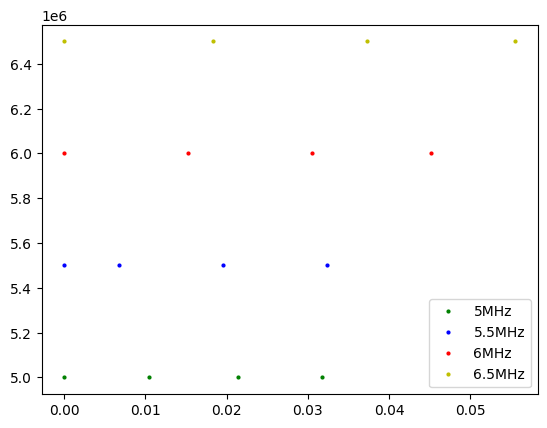

In [96]:
spread1 = np.array([firstPeakBs[0], secondPeakBs[0], thirdPeakBs[0], fourthPeakBs[0]])
spread1 = spread1 - spread1[0]
spread2 = np.array([firstPeakBs[1], secondPeakBs[1], thirdPeakBs[1], fourthPeakBs[1]])
spread2 = spread2 - spread2[0]
spread3 = np.array([firstPeakBs[2], secondPeakBs[2], thirdPeakBs[2], fourthPeakBs[2]])
spread3 = spread3 - spread3[0]
spread4 = np.array([firstPeakBs[3], secondPeakBs[3], thirdPeakBs[3], fourthPeakBs[3]])
spread4 = spread4 - spread4[0]

plt.plot(spread1, frequencies[0]*np.ones_like(spread1), "go", label='5MHz', markersize=2)
plt.plot(spread2, frequencies[1]*np.ones_like(spread1), "bo", label='5.5MHz', markersize=2)
plt.plot(spread3, frequencies[2]*np.ones_like(spread1), "ro", label='6MHz', markersize=2)
plt.plot(spread4, frequencies[3]*np.ones_like(spread1), "yo", label='6.5MHz', markersize=2)
plt.legend()
plt.show()